# Integración de transcriptomas de células individuales desde múltiples muestras

## Instalar las bibliotecas requeridas

In [ ]:
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
system("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)

Vamos a crear una función en R que ejecute comandos del sistema.

In [ ]:
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

Instalar bibliotecas requeridas

In [ ]:
# Instalar el paquete R.utils
install.packages("R.utils")

# Instalar una versión/commit específica del paquete Seurat Wrappers desde GitHub
remotes::install_github('satijalab/seurat-wrappers@d28512f804d5fe05e6d68900ca9221020d52cf1d', upgrade = FALSE)

# Instalar el paquete Seurat Data desde GitHub
remotes::install_github('satijalab/seurat-data')

# Verificar si el paquete BiocManager está instalado; si no lo está, instalarlo de forma silenciosa
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager", quiet = TRUE)

# Instalar el paquete Harmony para integrar conjuntos de datos de célula única
install.packages("harmony")

## Introducción

La integración es una técnica utilizada para combinar datos de células individuales provenientes de diferentes experimentos o condiciones en un único espacio de análisis. Esto es especialmente útil cuando se desea integrar datos de distintos lotes o condiciones para identificar patrones biológicos comunes.

En este ejemplo de integración de múltiples conjuntos de datos que representan, por ejemplo, diferentes condiciones biológicas, manipulación de muestras o protocolos experimentales, exploraremos la integración realizada por [Seurat](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8) y [Harmony](https://www.nature.com/articles/s41592-019-0619-0) por separado.

In [ ]:
# Cargar librerías
library(Seurat)
library(SeuratData)
library(SeuratWrappers)
library(cowplot)
library(harmony)
# Si el tiempo supera los 2000 segundos, el proceso se interrumpirá
options(timeout=2000)

## Carga de datos

Aquí cargamos los conjuntos de datos necesarios para realizar un análisis de integración.

Este tutorial demuestra el proceso de integración utilizando datos de células mononucleares de sangre periférica (PBMCs) del estudio de [Kang et al, 2017](https://www.nature.com/articles/nbt.4042). El experimento consistió en dividir las PBMCs en dos grupos: un grupo control y un grupo estimulado tratado con interferón beta. El tratamiento indujo cambios en la expresión génica específicos de cada tipo celular, lo que plantea un desafío para el análisis conjunto. Sin la integración, las células pueden agruparse según su condición de estimulación en lugar de por su identidad celular intrínseca, lo que complica la interpretación de los resultados.

Para aclarar, el objetivo de la integración es alinear los datos de ambos grupos en un espacio común donde las células se agrupen por tipo celular y no por condición de tratamiento. Este proceso es esencial para identificar con precisión características compartidas y únicas entre los conjuntos de datos, minimizando al mismo tiempo la influencia de efectos de lote introducidos por el diseño experimental.

Pasos a seguir:

1. Cargar los conjuntos de datos PBMCs: Usar datos de expresión génica preprocesados del estudio de Kang.
2. Inspeccionar la composición del conjunto de datos: Verificar que ambos grupos, control y estimulado, estén incluidos y que haya una representación adecuada de tipos celulares.
3. Realizar la integración: Utilizar herramientas de integración como Seurat o Harmony para combinar los conjuntos de datos considerando los efectos de lote.
4. Visualizar los resultados: Examinar los agrupamientos (clustering) para asegurarse de que las células se agrupen principalmente por tipo celular y no por condición de tratamiento.

Estos pasos aseguran una comparación sólida y biológicamente significativa entre los grupos PBMC control y estimulado.

In [ ]:
# instalar conjunto de datos
InstallData("ifnb")

In [ ]:
# cargar conjunto de datos
LoadData("ifnb")

In [ ]:
# Transferir los datos de ifnb a sc_dataset
sc_datasets <- ifnb

In [ ]:
# %>%: Este es el operador del paquete dplyr. Permite encadenar operaciones de manera legible, pasando el resultado de una operación como entrada a la siguiente.
# glimpse es una función del paquete dplyr que proporciona una vista rápida y concisa del conjunto de datos, mostrando los primeros valores de cada columna y sus respectivas clases.

sc_datasets %>% dplyr::glimpse()

## Preprocesamiento de Datos

Preprocesamos los datos hasta un punto común que sea compatible tanto con la integración de datos mediante Seurat como con Harmony

In [ ]:
# Actualizar el objeto Seurat al formato más reciente, corrigiendo problemas de compatibilidad con objetos Seurat antiguos
sc_datasets <- UpdateSeuratObject(object = sc_datasets) 
# Si se omite este paso, ocurre un error: 'no slot of name "images" for this object of class "Seurat"'

# Normalizar los datos de expresión génica en el objeto Seurat
sc_datasets <- Seurat::NormalizeData(sc_datasets, verbose = FALSE)

La función NormalizeData en Seurat simplifica los datos crudos de secuenciación de ARN de célula única (scRNA-seq) a una forma estandarizada, facilitando la comparación entre células y la detección de patrones biológicos significativos. Este proceso involucra tres pasos principales:

1. Escalado de conteos: Para cada gen, el conteo en una célula determinada se divide por el número total de conteos de todos los genes en esa célula. Esto corrige las diferencias en la profundidad de secuenciación entre células, asegurando comparaciones justas.

2. Ajuste de escala: El resultado del primer paso se multiplica por un factor de escalamiento (comúnmente establecido en 10.000). Esto hace que los valores normalizados sean más interpretables, asemejándose aproximadamente a conteos por cada 10.000 lecturas.

3. Transformación logarítmica: Finalmente, los conteos escalados se transforman utilizando una función logarítmica. Este paso reduce el efecto de valores extremadamente altos o bajos, facilitando la detección de patrones en los datos.

Este método es esencial porque garantiza que cualquier diferencia observada entre células refleje variaciones biológicas reales y no diferencias técnicas derivadas del proceso de secuenciación

In [ ]:
# Ver la estructura del objeto Seurat, incluyendo metadatos y datos de características
dplyr::glimpse(sc_datasets)

## Ejecutar la integración de datos con Seurat

La integración realizada aquí con Seurat consiste en utilizar un Análisis de Correlación Canónica (CCA) para identificar anclas entre los conjuntos de datos, tal como se indica en el [artículo original](https://www.cell.com/cell/fulltext/S0092-8674(19)30559-8):

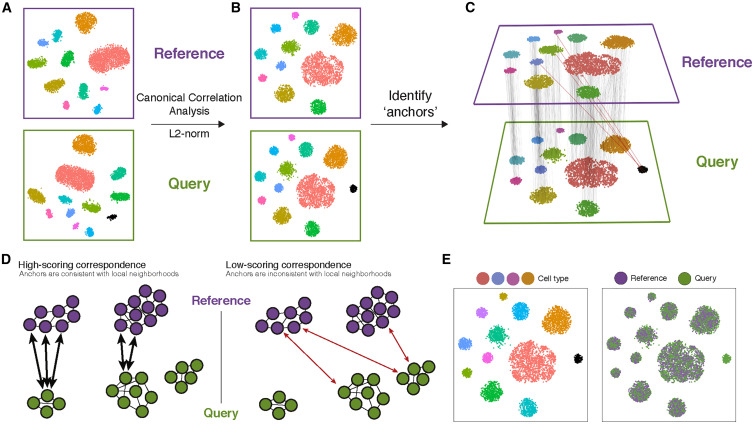

Dividir el conjunto de datos en una lista de conjuntos de datos

In [ ]:
# Dividir el objeto Seurat en una lista de objetos Seurat más pequeños según la columna de metadatos "stim"
sc_datasets.list <- SplitObject(sc_datasets, split.by = "stim")

Encontrar características altamente variables para cada condición por separado

In [ ]:
# Identificar las 2000 características variables principales para cada conjunto de datos en la lista
sc_datasets.list <- lapply(X = sc_datasets.list, FUN = function(x) {
                    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
                    })

Encontrar las características que son repetidamente variables entre los conjuntos de datos para la integración (características ancla).

In [ ]:
# Identificar las características de integración que se usarán para alinear los conjuntos de datos
features <- SelectIntegrationFeatures(object.list = sc_datasets.list)

Encontrar las anclas de integración o el conjunto final de genes altamente variables seleccionados con mayor frecuencia entre los lotes.

In [ ]:
# Encontrar anclas de integración entre los conjuntos de datos usando las características seleccionadas
sc_datasets.anchors <- FindIntegrationAnchors(object.list = sc_datasets.list, anchor.features = features)

# A continuación, se muestra un resumen del proceso en ejecución que aparecerá en tu pantalla

Integrar conjuntos de datos - Crea un ensayo de datos integrado

In [ ]:
# Integrar los conjuntos de datos en un único objeto Seurat usando las anclas de integración
sc_datasets.combined <- IntegrateData(anchorset = sc_datasets.anchors)

# A continuación, se muestra un resumen del proceso en ejecución que aparecerá en tu pantalla

In [ ]:
#  Ver la estructura del objeto Seurat integrado
dplyr::glimpse(sc_datasets.combined)

Ejecutar el flujo de trabajo estándar para visualización y agrupamiento.

In [ ]:
# Escalar los datos integrados, ejecutar PCA, realizar UMAP para reducción de dimensionalidad, encontrar vecinos y agrupar las células
sc_datasets.combined <- ScaleData(sc_datasets.combined, verbose = FALSE) %>%
                        RunPCA(npcs = 30, verbose = FALSE) %>%
                        RunUMAP(reduction = "pca", dims = 1:30) %>%
                        FindNeighbors(reduction = "pca", dims = 1:30) %>%
                        FindClusters(resolution = 0.5)

In [ ]:
# Establecer el tamaño de los gráficos para la visualización
options(repr.plot.height = 5, repr.plot.width = 16)

# Visualización: Crear gráficos UMAP con diferentes opciones de agrupamiento o etiquetado
p1 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")  # Agrupar células por metadatos "stim"
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)  # Etiquetar los clústeres en el UMAP
p3 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "seurat_annotations")  # Agrupar por anotaciones
p1 + p2 + p3  # Combinar los gráficos

## Ejecutar Harmony

Del [artículo original](https://www.nature.com/articles/s41592-019-0619-0) de harmony: "PCA incrusta las células en un espacio con dimensionalidad reducida. Harmony acepta las coordenadas celulares en este espacio reducido y ejecuta un algoritmo iterativo para ajustar los efectos específicos de cada conjunto de datos. 

**a.** Harmony utiliza agrupamiento difuso (fuzzy clustering) para asignar cada célula a múltiples grupos, mientras que un término de penalización asegura que se maximice la diversidad de conjuntos de datos dentro de cada grupo.

**b.** Harmony calcula un centroide global para cada grupo, así como centroides específicos para cada conjunto de datos dentro de cada grupo 

**c.** Dentro de cada grupo, Harmony calcula un factor de corrección para cada conjunto de datos basado en los centroides.

**d.** Finalmente, Harmony corrige cada célula con un factor específico para cada célula: una combinación lineal de los factores de corrección de los conjuntos de datos, ponderada por las asignaciones difusas de agrupamiento de la célula hechas en el paso a. Harmony repite los pasos a a d hasta la convergencia. La dependencia entre la asignación de grupo y el conjunto de datos disminuye con cada iteración. Los conjuntos de datos se representan con colores y los tipos celulares con diferentes formas."

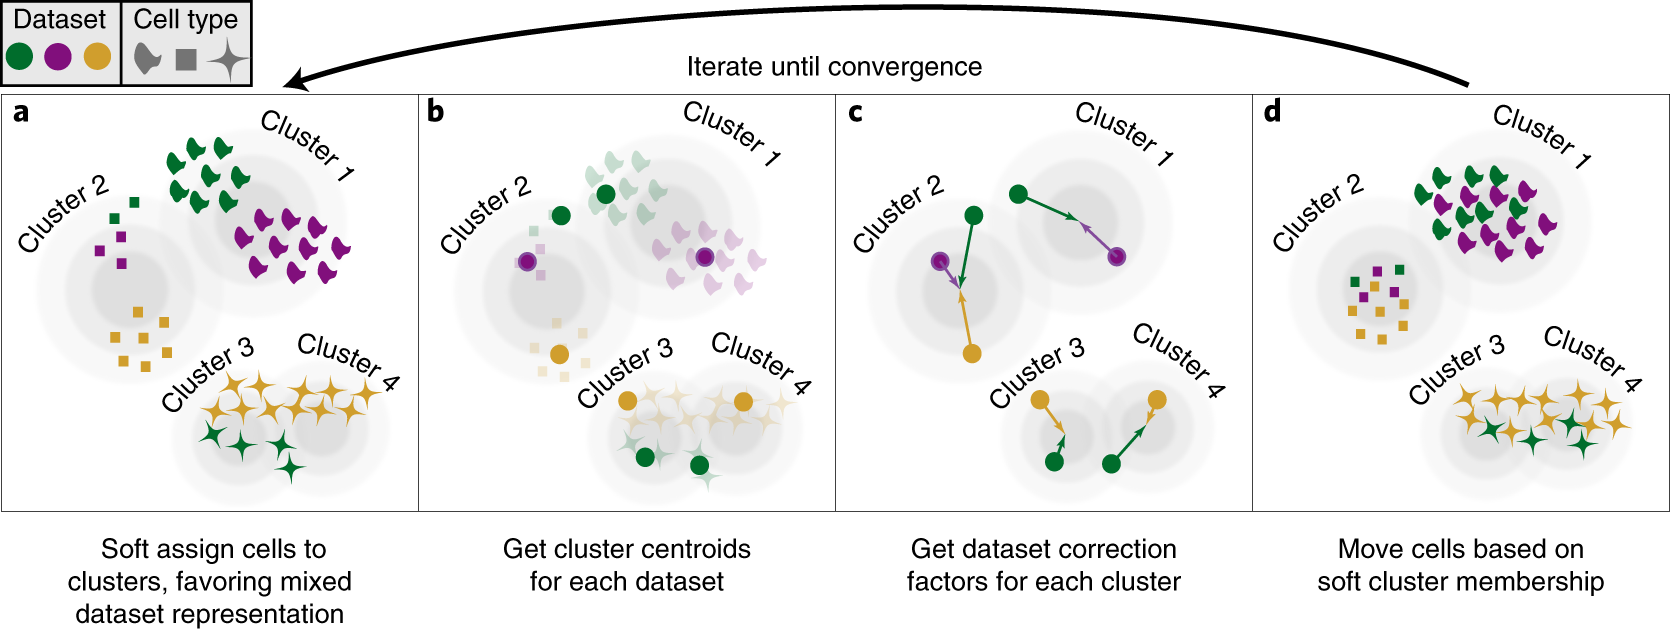



In [ ]:
# Establecer las dimensiones del gráfico para la visualización
options(repr.plot.height = 4, repr.plot.width = 6)

# Encontrar características variables, escalar datos, ejecutar PCA e integrar usando Harmony
sc_datasets.harmony <- FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                       ScaleData(verbose = FALSE) %>%
                       RunPCA(npcs = 30, verbose = FALSE) %>%
                       RunHarmony("stim", plot_convergence = TRUE)  # Integrar usando "stim" como variable de lote

Para acceder directamente a las incrustaciones armonizadas:


In [ ]:
# Extraer los embeddings de Harmony (representaciones en baja dimensión) y mostrar las primeras 5 filas y columnas
harmony_embeddings <- Embeddings(sc_datasets.harmony, 'harmony')
harmony_embeddings[1:5, 1:5]

Completa el flujo de trabajo estándar para visualización y agrupamiento.

In [ ]:
# Ejecutar UMAP usando los embeddings de Harmony, encontrar vecinos y agrupar las células
sc_datasets.harmony <- RunUMAP(sc_datasets.harmony, reduction = "harmony", dims = 1:30) %>%
                       FindNeighbors(reduction = "harmony", dims = 1:30) %>%
                       FindClusters(resolution = 0.5)

In [ ]:
# Establecer las dimensiones del gráfico para la visualización
options(repr.plot.height = 5, repr.plot.width = 16)

# Visualización: Crear gráficos UMAP con diferentes opciones de agrupamiento o etiquetado
p1 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")  # Agrupar por "stim"
p2 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)  # Etiquetar clústeres
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "seurat_annotations")  # Agrupar por anotaciones
p1 + p2 + p3  # Combinar los gráficos

## Métricas de integración

Inspeccionar el mix dentro del clúster

Usaremos una función para graficar la composición por lote de cada clúster.

Esta función fue tomada de: https://github.com/cellgeni/scRNA.seq.course/blob/master/course_files/utils/custom_seurat_functions.R

In [ ]:
# Definir una función personalizada para visualizar la distribución de clústeres en los datasets
plot_integrated_clusters = function(srat, batchcolumn) {
  ## Toma un objeto Seurat integrado y grafica la distribución según la columna "batchcolumn"
  library(Seurat)
  library(patchwork)
  library(ggplot2)
  library(reshape2)
  library(RColorBrewer)

  # Crear una tabla de conteo de células por clúster y dataset
  count_table <- table(srat@meta.data$seurat_clusters, srat@meta.data[[batchcolumn]])
  count_mtx   <- as.data.frame.matrix(count_table)  # Convertir tabla a data frame
  count_mtx$cluster <- rownames(count_mtx)  # Agregar identificadores de clúster como columna
  melt_mtx    <- melt(count_mtx)  # Reestructurar datos para ggplot
  melt_mtx$cluster <- as.factor(melt_mtx$cluster)  # Convertir la columna cluster en factor

  # Calcular el tamaño de cada clúster
  cluster_size   <- aggregate(value ~ cluster, data = melt_mtx, FUN = sum)

  # Ordenar clústeres por tamaño
  sorted_labels <- paste(sort(as.integer(levels(cluster_size$cluster)), decreasing = TRUE))
  cluster_size$cluster <- factor(cluster_size$cluster, levels = sorted_labels)
  melt_mtx$cluster <- factor(melt_mtx$cluster, levels = sorted_labels)

  colnames(melt_mtx)[2] <- "dataset"  # Renombrar columna para mayor claridad

  # Graficar la distribución de células por clúster (escala logarítmica)
  p1 <- ggplot(cluster_size, aes(y = cluster, x = value)) +
        geom_bar(position = "dodge", stat = "identity", fill = "grey60") +
        theme_bw() + scale_x_log10() + xlab("Cells per cluster, log10 scale") + ylab("")

  # Graficar la fracción de células en cada dataset para cada clúster
  p2 <- ggplot(melt_mtx, aes(x = cluster, y = value, fill = dataset)) +
        geom_bar(position = "fill", stat = "identity") +
        theme_bw() + coord_flip() +
        scale_fill_brewer(palette = "Set2") +
        ylab("Fraction of cells in each dataset") + xlab("Cluster number") + theme(legend.position = "top")

  p2 + p1 + plot_layout(widths = c(3, 1))  # Combinar gráficos
}

In [ ]:
# Visualizar clústeres para datasets integrados
plot_integrated_clusters(sc_datasets.combined, 'stim')

In [ ]:
# Visualizar clústeres para Harmony
plot_integrated_clusters(sc_datasets.harmony, 'stim')

Esto mide qué tan bien mezclado está un conjunto de datos compuesto. Según [este enlace](https://github.com/satijalab/Integration2019/issues/1#issuecomment-573757488), untuaciones más bajas representan una mejor mezcla. Ver también [este código](https://github.com/satijalab/Integration2019/blob/e5821bd242fa0a46eb6fd37764275737512032a4/analysis_code/integration/integration_metrics.R#L43C1-L45C124)

Esta métrica evalúa si el vecindario de una célula está bien mezclado. En otras palabras, si contiene una pequeña cantidad de células de cada conjunto de datos (por ejemplo, k = 5).

In [ ]:
# Calcular la métrica de mezcla para los datos integrados con Seurat
seurat_mixing <- MixingMetric(sc_datasets.combined,
                              'seurat_clusters',  # Columna para evaluar la mezcla
                              reduction = "pca",  # Usar las embeddings de PCA
                              dims = 1:2,         # Evaluar las dos primeras dimensiones
                              k = 5,              # Número de vecinos más cercanos
                              max.k = 300,        # Número máximo de vecinos
                              eps = 0,            # Tolerancia para la búsqueda de vecinos
                              verbose = TRUE      # Mostrar progreso
                             )

In [ ]:
# Calcular el promedio de la métrica de mezcla de Seurat
mean(seurat_mixing)

In [ ]:
# Calcular la desviación estándar de la métrica de mezcla de Seurat
sd(seurat_mixing)

In [ ]:
# Calcular la métrica de mezcla para los datos integrados con Harmony
harmony_mixing <- MixingMetric(sc_datasets.harmony,
                               'seurat_clusters',
                               reduction = "harmony",
                               dims = 1:2,
                               k = 5,
                               max.k = 300,
                               eps = 0,
                               verbose = TRUE
                             )

In [ ]:
# Calcular el promedio de la métrica de mezcla de Harmony
mean(harmony_mixing)

In [ ]:
# Calcular la desviación estándar de la métrica de mezcla de Harmony
sd(harmony_mixing)

# Comparemos al no usar integración, con Seurat y con Harmony:

In [ ]:
# Identificar las 2000 características (genes) más variables usando el método "vst".
# Estas características se utilizan para análisis posteriores.
sc_datasets <- FindVariableFeatures(sc_datasets, selection.method = "vst", nfeatures = 2000) %>%
                
                # Escalar y centrar los datos para las características variables identificadas.  
                # Esto estandariza los valores de expresión entre las células.
                ScaleData(verbose = FALSE) %>%
                
                # Realizar un Análisis de Componentes Principales (PCA) para reducir la dimensionalidad.  
                # Conservar los primeros 30 componentes principales para análisis posteriores. 
                RunPCA(npcs = 30, verbose = FALSE) %>%
                
                # Aplicar Uniform Manifold Approximation and Projection (UMAP) para reducción no lineal de dimensionalidad.  
                # Usar los resultados de PCA como entrada y los primeros 30 componentes principales.
                RunUMAP(reduction = "pca", dims = 1:30) %>%
                
                # Calcular un grafo de vecinos más cercanos compartidos (SNN) para agrupamiento.
                # Este paso identifica relaciones entre células basadas en sus embeddings UMAP.
                FindNeighbors(reduction = "pca", dims = 1:30) %>%
                
                # Realizar la agrupación (clustering) de células usando el grafo SNN.
                # La resolución controla la granularidad de los grupos (mayor resolución = más grupos).
                FindClusters(resolution = 0.5)

In [ ]:
# Establecer el tamaño de la visualización de salida.
options(repr.plot.height = 5, repr.plot.width = 16)

# Crear un gráfico UMAP agrupando las células según la columna de metadatos "stim".
p1 <- DimPlot(sc_datasets, reduction = "umap", group.by = "stim")

# Crear un gráfico UMAP para el conjunto de datos integrado, agrupando las células según la columna de metadatos "stim".
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", group.by = "stim")

# Crear un gráfico UMAP para el conjunto de datos corregido con Harmony, agrupando las células según la columna de metadatos "stim".
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", group.by = "stim")

# Combinar los tres gráficos UMAP (p1, p2 y p3) en una sola visualización.
p1 + p2 + p3

In [ ]:
# Establecer la altura y anchura de la visualización de salida.
options(repr.plot.height = 5, repr.plot.width = 16)

# Crear un gráfico UMAP para el objeto original sc_datasets.
# El parámetro 'label' añade etiquetas a los clústeres en el gráfico.
# El parámetro 'repel' evita que las etiquetas de texto se superpongan.
p1 <- DimPlot(sc_datasets, reduction = "umap", label = TRUE, repel = TRUE)

# Crear un gráfico UMAP para el objeto combinado sc_datasets.
p2 <- DimPlot(sc_datasets.combined, reduction = "umap", label = TRUE, repel = TRUE)

# Crear un gráfico UMAP para el objeto sc_datasets corregido con Harmony.
# Este gráfico también usa UMAP, con etiquetas y repelente para evitar superposiciones.
p3 <- DimPlot(sc_datasets.harmony, reduction = "umap", label = TRUE, repel = TRUE)

p1 + p2 + p3 # Combinar los gráficos

## Preguntas adicionales:

¿Qué tan diferentes son los resultados entre la integración con Seurat y Harmony?

¿Por qué puede ocurrir esto?

¿Puedes identificar qué marcadores cambiaron en los clústeres generados por un método versus el otro?

In [38]:
?DimPlot